## Performing Real-Time Test

In [29]:
import cv2
import numpy as np
import mediapipe as mp
import pickle
import matplotlib.pyplot as plt

In [18]:
from Extracting_Landmarks import extract_keypoints , mp_holistic , mp_drawing , mediapipe_detection , drawing_styled_landmarks

In [19]:
actions = np.array(['hello' , 'thankyou' , 'iloveyou'])

Importing model

In [20]:
with open('LSTM_model' , 'rb') as file:
  
  model = pickle.load(file)

c:\Users\Sahil\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\saving\saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 17 variables whereas the saved optimizer has 32 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [21]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_3 (LSTM)                   │ (None, 30, 64)         │       442,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ (None, 30, 128)        │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,193,352 (4.55 MB)

 Trainable params: 596,675 (2.28 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 596,677 (2.28 MB)

Displaying probability for words

In [28]:
colors = [(245 , 117 , 16) , (117 , 245 , 16) , (16 , 117 , 245)]

def prob_visualization(res , actions , input_frame , colors):
  
  output_frame = input_frame.copy()
  for num , prob in enumerate(res):
    cv2.rectangle(output_frame ,(0 , 60 + num*40) , (int(prob*100), 90+num*40) , colors[num] , -1)
    cv2.putText(output_frame , actions[num] , (0, 85 + num*40) , cv2.FONT_HERSHEY_SIMPLEX , 1 , (255 , 255 , 255) , 2 , cv2.LINE_AA)
  
  return output_frame

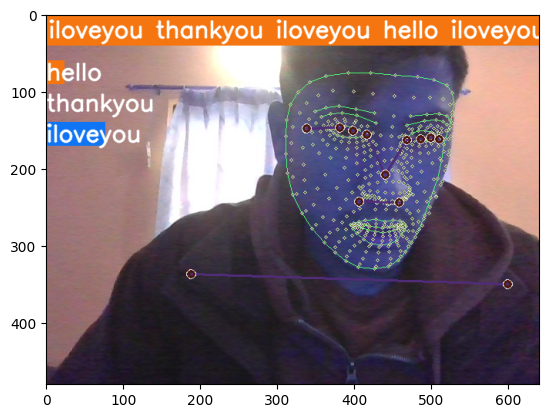

In [31]:
plt.imshow(prob_visualization(res,actions,image , colors))

In [37]:
# Checking video camera availablity 

sequence = []
sentence = []
threshold = 0.7
res = None
predictions = []
 
cap = cv2.VideoCapture(0)  # accesses the webcam

with mp_holistic.Holistic(min_detection_confidence= 0.7 , min_tracking_confidence= 0.7) as holistic:
   while cap.isOpened():  #This loop continiously read frames from the camera cap

      # Reading the frames
      ret , frame = cap.read() # ret is a boolean variable that is True is a frame is being read

      # Using Detection Function

      image , landmark_results = mediapipe_detection(frame , holistic )
      print(landmark_results)

      #Drawing Landmarks onto the frames on the screen
      drawing_styled_landmarks(image , landmark_results)

      # Adding prediction logic
      keypoints = extract_keypoints(landmark_results)
      sequence.append(keypoints)
      sequence = sequence[-30:]
   

      if len(sequence) == 30:
         res = model.predict(np.expand_dims(sequence , axis = 0 ))[0]
         predictions.append(np.argmax(res))

      # Visualization logic
      
      if len(predictions) >= 10 and np.unique(predictions[-10:])[0] == np.argmax(res):
         if res is not None and res[np.argmax(res)] > threshold:

            if len(sentence) > 0:

               if actions[np.argmax(res)] != sentence[-1]:
                  sentence.append(actions[np.argmax(res)])
            
            else: 

               sentence.append(actions[np.argmax(res)])
      
      if len(sentence) > 5:
         sentence = sentence[-5:]
      
      #Prob Viz
      if res is not None:
       image = prob_visualization(res , actions , image , colors)

      cv2.rectangle(image, (0, 0), (image.shape[1], 40), (245, 117, 16), -1)
      cv2.putText(image , ' '.join(sentence) , (3,30) , cv2.FONT_HERSHEY_SIMPLEX , 1 , (255 , 255 , 255) , 2 , cv2.LINE_AA)

      # Displaying frames to screen 
      cv2.imshow('OpenCV' , image) 

      if cv2.waitKey(10) & 0xFF == ord('q'):
         break
      
   cap.release()
   cv2.destroyAllWindows()

<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.soluti